# 05 — Prescriptive Recommender System

**Amaç:** 04. notebook'ta eğitilen dürüst "Conversion Predictor" modelini kullanarak, her müşteri için **hangi Kampanya Kanalı + Platform** ikilisinin dönüşüm olasılığını en çok artıracağını öneren bir **Prescriptive (Reçeteleyici) Öneri Sistemi** kurmak.

**Akış:** 1) Varlık yükleme (model, scaler, imputer, test verisi) → 2) Strateji simülasyonu (`recommend_action`) → 3) Performans Lift analizi → 4) Segment–kanal heatmap ve feature importance ilişkisi.

## Predictive vs Prescriptive Analitik

- **Predictive (Tahmine dayalı):** "Ne olacak?" sorusuna cevap verir. Örneğin: Bu müşterinin mevcut kanal/platform ile dönüşüm yapma olasılığı nedir?
- **Prescriptive (Reçeteleyici):** "Ne yapmalıyız?" sorusuna cevap verir. Örneğin: Bu müşteriyi dönüştürmek için hangi kanal+platform kombinasyonunu kullanmalıyız?

Bu notebook'ta, aynı tahmin modelini **simülasyon** ile kullanıyoruz: Tüm olası aksiyonları (kanal+platform çiftleri) deneyip en yüksek dönüşüm olasılığını veren aksiyonu **öneri** olarak sunuyoruz. Yani model pasif bir tahminci olmaktan çıkıp **aktif bir strateji motoru**na dönüşüyor.

## Model Persistence: Neden .pkl Dosyaları?

04. notebook'ta eğitilen model, scaler ve imputer **disk üzerinde** `.pkl` (pickle) dosyaları olarak kaydedildi. Böylece:

1. **Yeniden eğitim gerekmez:** Aynı pipeline (özellik hazırlama → impute → scale → tahmin) başka bir ortamda (bu notebook, API, vb.) tekrarlanabilir.
2. **Versiyonlama:** Hangi modelin kullanıldığı nettir (`models/final_model.pkl`).
3. **Tutarlılık:** Scaler ve imputer, eğitim verisi üzerinde fit edildiği için test/öneri verisinde **aynı dönüşümler** uygulanmalıdır; bu dosyalar olmadan özellik uzayı uyumsuz kalır.

Bu notebook, `models/final_model.pkl`, `models/scaler.pkl` ve `models/imputer.pkl` dosyalarını yükleyerek 04. notebook ile **aynı** modeli kullanır.

## Klasik User-Based Collaborative Filtering'dan Farkı

- **User-Based CF:** "Senin gibi kullanıcılar şunu beğendi" der; benzer kullanıcıların geçmiş davranışına dayanır. Çıktı genelde **ürün/içerik önerisi** (rating/item).
- **Bu sistem:** Müşteri **profil özelliklerine** (yaş, gelir, geçmiş alışveriş vb.) ve **alabileceğimiz aksiyona** (hangi kanal+platform) bakarak, **dönüşüm olasılığını maksimize eden aksiyonu** önerir. Yani **aksiyon odaklı (action-oriented)** bir prescriptive sistemdir; "kime ne yapmalıyız?" sorusuna yanıt verir.

## 1. Asset Retrieval

Aşağıda 04. notebook ile uyumlu olacak şekilde:
- `models/final_model.pkl`, `scaler.pkl`, `imputer.pkl` yükleniyor.
- `marketing_analytics_featured.csv` üzerinden veri alınıyor; ROI_v2 ve CPA_v2 eklenip **Scenario D** feature seti ile `prepare_X` uygulanıyor.
- Aynı `random_state` ile train/test split yapılarak **test seti** elde ediliyor (lift analizi için).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")
RANDOM_STATE = 42

# --- Model, scaler, imputer yükleme (04. notebook ile aynı yol) ---
MODELS_DIR = "../models"
path_model = os.path.join(MODELS_DIR, "final_model.pkl")
path_scaler = os.path.join(MODELS_DIR, "scaler.pkl")
path_imputer = os.path.join(MODELS_DIR, "imputer.pkl")

assert os.path.exists(
    path_model), f"Model bulunamadı: {path_model}. Önce 04_model_comparison.ipynb çalıştırıp modeli kaydedin."
model = joblib.load(path_model)
scaler = joblib.load(path_scaler)
imputer = joblib.load(path_imputer)
print("Yüklendi: final_model, scaler, imputer")

Yüklendi: final_model, scaler, imputer


In [2]:
print("Yüklendi: final_model, scaler, imputer")
# --- Veri yükleme (04 ile aynı kaynak) ---
path_data = "../data/marketing_analytics_featured.csv"
df = pd.read_csv(path_data)
y = df["Conversion"]

Yüklendi: final_model, scaler, imputer


In [3]:
# 04. notebook'taki gibi ROI_v2 ve CPA_v2 ekle (Scenario E/D feature seti için)
df["ROI_v2"] = (df["Income"] * df["ClickThroughRate"]) / (df["AdSpend"].replace(0, np.nan).fillna(1) + 1)
df["CPA_v2"] = df["AdSpend"] / (df["WebsiteVisits"].replace(0, np.nan).fillna(1) + 1)

In [4]:
for c in ["ROI_v2", "CPA_v2"]:
    df[c] = df[c].replace([np.inf, -np.inf], np.nan)
    df[c] = df[c].clip(upper=df[c].quantile(0.995))

In [5]:
# Scenario D: 04 ile aynı drop listesi
BASE_DROP = ["CustomerID", "Conversion"]
SCENARIOS = {
    "D": BASE_DROP + ["ConversionRate", "CTR_to_Conversion", "ROI_Proxy", "CPA_Proxy"],
}


In [6]:
def prepare_X(data, drop_cols):
    """drop_cols içindeki sütunları çıkarır, kategorikleri one-hot encode eder (04 ile aynı)."""
    to_drop = [c for c in drop_cols if c in data.columns]
    X = data.drop(columns=to_drop, errors="ignore")
    X = pd.get_dummies(X, drop_first=True)
    for c in X.select_dtypes(include=["bool"]).columns:
        X[c] = X[c].astype(int)
    return X

In [7]:
X_all = prepare_X(df, SCENARIOS["D"])
feature_columns = X_all.columns.tolist()
print("Feature sayısı:", len(feature_columns))

Feature sayısı: 55


In [8]:
# --- Train/Test split (04 ile aynı; test seti lift analizi için) ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
# Test setindeki orijinal satır indeksleri (df üzerinden test müşterilerine erişim için)
train_idx, test_idx = train_test_split(
    np.arange(len(df)), test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
df_test = df.iloc[test_idx].reset_index(drop=True)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)
X_test_s = scaler.transform(X_test_imputed)
print("Test seti boyutu:", len(df_test))

Test seti boyutu: 9600


## 2. Strategy Simulation Logic: `recommend_action(customer_data)`

Fonksiyon:
1. Verilen **müşteri profilini** (tek satır) alır; sabit özellikleri (Age, Income, vb.) korur.
2. **Değişken özellikleri** (CampaignChannel, AdvertisingPlatform) tüm olası kombinasyonlarla **cross-join** yaparak bir "simülasyon veri seti" oluşturur.
3. Bu simülasyonu 04 ile aynı pipeline üzerinden geçirir (prepare_X → imputer → scaler → model).
4. Her kanal/platform ikilisi için **Conversion Probability** hesaplar; en yüksek olasılığı veren kombinasyonu **Recommended Action** olarak döner.

In [9]:
# Tüm kanal ve platform değerleri (df'den; simülasyon için)
CHANNELS = df["CampaignChannel"].dropna().unique().tolist()
PLATFORMS = df["AdvertisingPlatform"].dropna().unique().tolist()
print("Kanal sayısı:", len(CHANNELS), "| Platform sayısı:", len(PLATFORMS))

Kanal sayısı: 7 | Platform sayısı: 7


In [10]:
def recommend_action(customer_data, model=model, scaler=scaler, imputer=imputer,
                     feature_columns=feature_columns, channels=CHANNELS, platforms=PLATFORMS,
                     prepare_X=prepare_X, drop_cols=None):
    """
    Bir müşteri profilini alır; tüm (CampaignChannel, AdvertisingPlatform) kombinasyonları
    için dönüşüm olasılığını hesaplar ve en yüksek olasılığı veren aksiyonu önerir.

    customer_data: df'den tek satır (Series) veya dict. Sabit özellikler korunur;
                   sadece CampaignChannel ve AdvertisingPlatform varyasyonları üretilir.
    Returns: dict with recommended_channel, recommended_platform, max_prob, prob_frame (tüm kombinasyonlar).
    """
    if drop_cols is None:
        drop_cols = SCENARIOS["D"]
    # Tek satırlık DataFrame yap
    if isinstance(customer_data, pd.Series):
        row_df = customer_data.to_frame().T
    else:
        row_df = pd.DataFrame([customer_data])

    # Simülasyon: her (kanal, platform) çifti için aynı müşteri profilini kopyala
    rows = []
    for ch in channels:
        for pl in platforms:
            r = row_df.copy()
            r["CampaignChannel"] = ch
            r["AdvertisingPlatform"] = pl
            rows.append(r)
    sim_df = pd.concat(rows, ignore_index=True)

    # Özellik matrisi (04 ile aynı prepare_X)
    X_sim = prepare_X(sim_df, drop_cols)
    # Model eğitiminde kullanılan sütun sırası ve eksik sütunları 0 ile doldur
    X_sim = X_sim.reindex(columns=feature_columns, fill_value=0)
    X_sim_imp = pd.DataFrame(imputer.transform(X_sim), columns=feature_columns, index=X_sim.index)
    X_sim_s = scaler.transform(X_sim_imp)
    probs = model.predict_proba(X_sim_s)[:, 1]

    # Her satır (ch, pl) çiftine karşılık geliyor; sıra: channels x platforms (önce platform değişir)
    prob_frame = pd.DataFrame({
        "CampaignChannel": [ch for ch in channels for _ in platforms],
        "AdvertisingPlatform": [pl for _ in channels for pl in platforms],
        "Conversion_Probability": probs,
    })
    best_idx = np.argmax(probs)
    best_row = prob_frame.iloc[best_idx]
    return {
        "recommended_channel": best_row["CampaignChannel"],
        "recommended_platform": best_row["AdvertisingPlatform"],
        "max_prob": best_row["Conversion_Probability"],
        "prob_frame": prob_frame,
    }

In [11]:
# Örnek: Test setinden bir müşteri için öneri
sample_customer = df_test.iloc[0]
rec = recommend_action(sample_customer)
print("Örnek müşteri için önerilen aksiyon:", rec["recommended_channel"], "+", rec["recommended_platform"])
print("Tahmini dönüşüm olasılığı:", round(rec["max_prob"], 4))
rec["prob_frame"].sort_values("Conversion_Probability", ascending=False).head()

Örnek müşteri için önerilen aksiyon: Display + LinkedIn
Tahmini dönüşüm olasılığı: 0.1082


,CampaignChannel,AdvertisingPlatform,Conversion_Probability
35,Display,LinkedIn,0.108249
37,Display,Facebook,0.106752
28,Email,LinkedIn,0.103431
36,Display,Instagram,0.102654
30,Email,Facebook,0.101993


## 3. Performance Lift Analysis

Tüm test seti için:
- **Gerçekte kullanılan kanal/platform** ile modelin tahmin ettiği dönüşüm olasılığı (mevcut aksiyonun prob'u).
- **Modelin önerdiği kanal/platform** ile tahmin edilen dönüşüm olasılığı (önerilen aksiyonun prob'u).

Aradaki fark **Expected Lift** (beklenen artış) olarak raporlanır: Öneriyi uygularsak ortalama ne kadar olasılık artışı beklenir?

In [12]:
# Her test müşterisi için: (1) gerçekte kullanılan kanalın prob'u, (2) önerilen kanalın prob'u
prob_actual_list = []
prob_recommended_list = []
recommended_channel_list = []
recommended_platform_list = []

In [13]:
for i in range(len(df_test)):
    row = df_test.iloc[i]
    rec = recommend_action(row)
    # Gerçekte kullanılan (ch, pl) kombinasyonunun prob'unu bul
    pf = rec["prob_frame"]
    actual_ch = row["CampaignChannel"]
    actual_pl = row["AdvertisingPlatform"]
    mask = (pf["CampaignChannel"] == actual_ch) & (pf["AdvertisingPlatform"] == actual_pl)
    if mask.any():
        prob_actual = pf.loc[mask, "Conversion_Probability"].iloc[0]
    else:
        prob_actual = np.nan  # veride olmayan bir kombinasyon
    prob_actual_list.append(prob_actual)
    prob_recommended_list.append(rec["max_prob"])
    recommended_channel_list.append(rec["recommended_channel"])
    recommended_platform_list.append(rec["recommended_platform"])


In [14]:
lift_df = pd.DataFrame({
    "prob_actual": prob_actual_list,
    "prob_recommended": prob_recommended_list,
    "recommended_channel": recommended_channel_list,
    "recommended_platform": recommended_platform_list,
})
lift_df["lift"] = lift_df["prob_recommended"] - lift_df["prob_actual"]

In [15]:
# NaN'ları (gerçek kombinasyon bulunamayan) çıkararak ortalama lift
valid = lift_df["prob_actual"].notna()
expected_lift = lift_df.loc[valid, "lift"].mean()
print("Expected Lift (ortalama olasılık artışı, öneri uygulanırsa):", round(expected_lift, 4))
lift_df.describe()

Expected Lift (ortalama olasılık artışı, öneri uygulanırsa): 0.0227


,prob_actual,prob_recommended,lift
count,9600.000000,9600.000000,9600.000000
mean,0.085524,0.108249,0.022725
std,0.009712,0.000000,0.009712
min,0.067152,0.108249,0.000000
25%,0.079269,0.108249,0.015087
50%,0.084706,0.108249,0.023543
75%,0.093162,0.108249,0.028980
max,0.108249,0.108249,0.041096


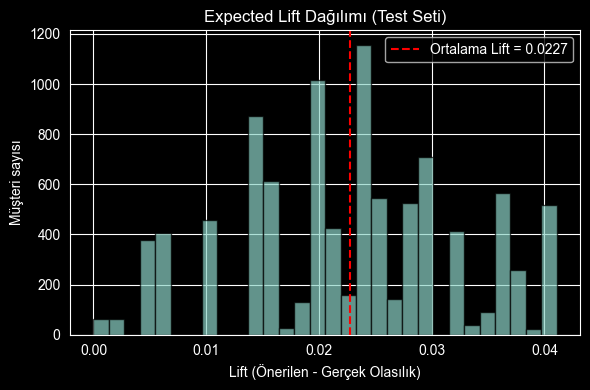

In [16]:
# Lift dağılımı
fig, ax = plt.subplots(figsize=(6, 4))
lift_df.loc[valid, "lift"].hist(bins=30, ax=ax, edgecolor="black", alpha=0.7)
ax.axvline(expected_lift, color="red", linestyle="--", label=f"Ortalama Lift = {expected_lift:.4f}")
ax.set_xlabel("Lift (Önerilen - Gerçek Olasılık)")
ax.set_ylabel("Müşteri sayısı")
ax.set_title("Expected Lift Dağılımı (Test Seti)")
ax.legend()
plt.tight_layout()
plt.show()

## 4. Insights & Visualization

- **Heatmap:** Hangi müşteri segmentine (ör. Yaş Grubu × Gelir Tier) hangi kanalların önerildiğini gösterir.
- **Feature Importance:** Öneri sisteminin kararlarını, 04. notebook'taki modelin feature importance'ı ile ilişkilendiririz (hangi özellikler öneriyi yönlendiriyor).

In [17]:
# Test setine önerilen kanal/platform ekle
df_test_rec = df_test.copy()
df_test_rec["recommended_channel"] = recommended_channel_list
df_test_rec["recommended_platform"] = recommended_platform_list

In [18]:
# Segment: Age_Group x Income_Tier (varsa); yoksa Age ve Income bantları kullan
for col in ["Age_Group", "Income_Tier"]:
    if col not in df_test_rec.columns:
        if col == "Age_Group":
            df_test_rec["Age_Group"] = pd.cut(df_test_rec["Age"], bins=[0, 25, 35, 45, 55, 100], labels=["18-25", "26-35", "36-45", "46-55", "55+"])
        elif col == "Income_Tier":
            df_test_rec["Income_Tier"] = pd.qcut(df_test_rec["Income"].rank(method="first"), q=3, labels=["Low", "Mid", "High"])


In [19]:
# Heatmap: Segment (Age_Group x Income_Tier) -> Önerilen Kanal (en sık önerilen)
cross = pd.crosstab(
    [df_test_rec["Age_Group"].astype(str), df_test_rec["Income_Tier"].astype(str)],
    df_test_rec["recommended_channel"],
    normalize="index",
)

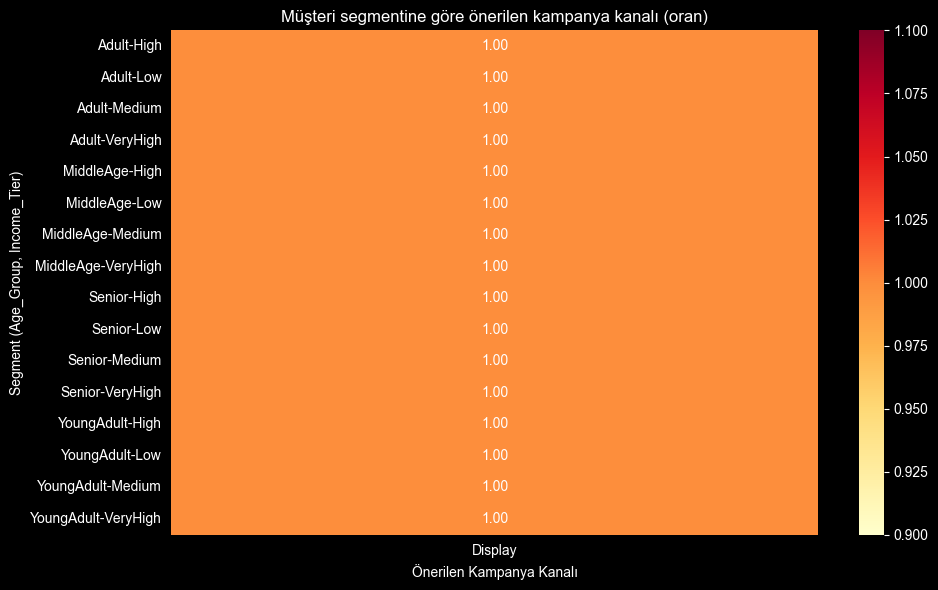

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cross, annot=True, fmt=".2f", cmap="YlOrRd", ax=ax)
ax.set_title("Müşteri segmentine göre önerilen kampanya kanalı (oran)")
ax.set_xlabel("Önerilen Kampanya Kanalı")
ax.set_ylabel("Segment (Age_Group, Income_Tier)")
plt.tight_layout()
os.makedirs("../reports/05_recommender", exist_ok=True)
plt.savefig("../reports/05_recommender/segment_channel_heatmap.png", dpi=120, bbox_inches="tight")
plt.show()

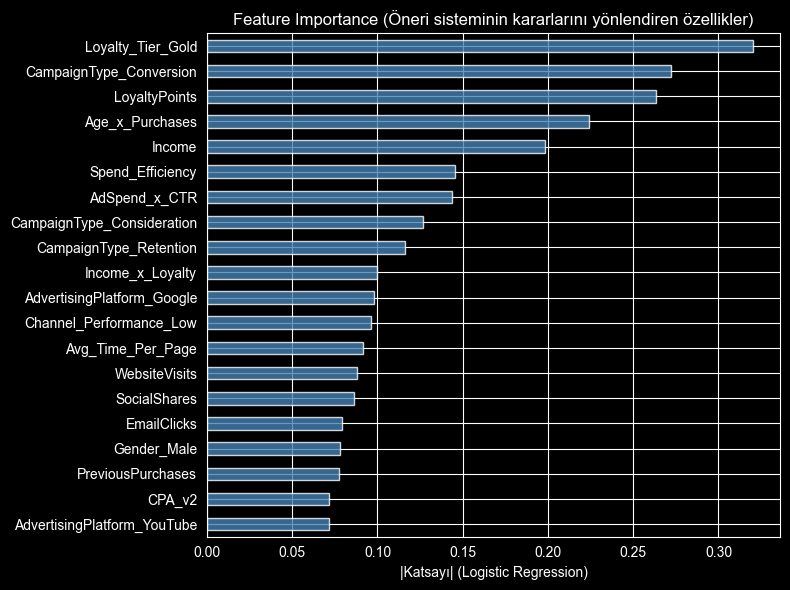

In [21]:
# Feature Importance: 04'teki final model LogisticRegression; katsayılar önem sırası verir
if hasattr(model, "coef_"):
    imp = np.abs(model.coef_[0])
    imp_series = pd.Series(imp, index=feature_columns).sort_values(ascending=False)
    top_n = min(20, len(imp_series))
    fig, ax = plt.subplots(figsize=(8, 6))
    imp_series.head(top_n).plot(kind="barh", ax=ax, color="steelblue", alpha=0.8)
    ax.set_xlabel("|Katsayı| (Logistic Regression)")
    ax.set_title("Feature Importance (Öneri sisteminin kararlarını yönlendiren özellikler)")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig("../reports/05_recommender/feature_importance.png", dpi=120, bbox_inches="tight")
    plt.show()
else:
    # Tree-based model ise feature_importances_
    imp = model.feature_importances_
    imp_series = pd.Series(imp, index=feature_columns).sort_values(ascending=False)
    imp_series.head(20).plot(kind="barh", figsize=(8, 6), title="Feature Importance")
    plt.tight_layout()
    plt.savefig("../reports/05_recommender/feature_importance.png", dpi=120, bbox_inches="tight")
    plt.show()

**Yorum:** Yukarıdaki feature importance, modelin dönüşüm tahmininde hangi özelliklere daha çok ağırlık verdiğini gösterir. Öneri sistemi, bu aynı modeli kullanarak "hangi kanal+platform" kombinasyonunun bu özelliklerle birlikte en yüksek olasılığı verdiğini seçer. Dolayısıyla özellikle **CampaignChannel** ve **AdvertisingPlatform** ile etkileşim halinde olan veya segmentasyonu yansıtan (ör. Income, Age, Loyalty) özellikler öneriyi güçlü biçimde etkiler. Gerçekçi (~0.15 F1 civarı) bir tahminci kullandığımız için öneriler de bu sınırlar içinde anlamlıdır.

---
# Phase 3: Segment-Specific Deep Dive (Final Teşhis)

Önerilerin genel ortalamada homojen çıkması, gizli segment bazlı trendleri maskeliyor olabilir. Bu bölümde gelir ve yaş kırılımında segment-spesifik tercihleri inceliyoruz.

## 3.1 Income Segmentation

Veriyi **Income** (Gelir) medyanına göre "High-Income" ve "Low-Income" olarak ikiye ayırıyoruz. Her iki grup için mevcut `recommend_action` mantığıyla öneri simülasyonu çalıştırıp, en çok önerilen **Kanal + Platform** ikilisini karşılaştırıyoruz.

In [22]:
# Gelir medyanına göre test setini ikiye ayır
income_median = df_test["Income"].median()
df_test_income = df_test.copy()
df_test_income["Income_Segment"] = df_test_income["Income"].apply(
    lambda x: "High-Income" if x >= income_median else "Low-Income"
)


In [23]:
# Her iki segment için öneri simülasyonu (zaten lift_df ve recommended_* listeleri var; segment etiketini ekleyip grupla)
seg_income = df_test_income["Income_Segment"].values
rec_high = pd.Series(recommended_channel_list)[np.array(seg_income) == "High-Income"]
rec_low = pd.Series(recommended_channel_list)[np.array(seg_income) == "Low-Income"]

In [24]:
# En çok önerilen kanal (ve platform) her segmentte
platform_list = np.array(recommended_platform_list)
platform_high = platform_list[np.array(seg_income) == "High-Income"]
platform_low = platform_list[np.array(seg_income) == "Low-Income"]

In [25]:
top_channel_high = rec_high.mode().iloc[0] if len(rec_high) else None
top_channel_low = rec_low.mode().iloc[0] if len(rec_low) else None
top_platform_high = pd.Series(platform_high).mode().iloc[0] if len(platform_high) else None
top_platform_low = pd.Series(platform_low).mode().iloc[0] if len(platform_low) else None

In [26]:
print("High-Income segmentinde en çok önerilen: Kanal =", top_channel_high, "| Platform =", top_platform_high)
print("Low-Income segmentinde en çok önerilen: Kanal =", top_channel_low, "| Platform =", top_platform_low)
print("\nKıyas: Gelir segmentine göre önerilen kanal/platform farklı mı?", top_channel_high != top_channel_low or top_platform_high != top_platform_low)

High-Income segmentinde en çok önerilen: Kanal = Display | Platform = LinkedIn
Low-Income segmentinde en çok önerilen: Kanal = Display | Platform = LinkedIn

Kıyas: Gelir segmentine göre önerilen kanal/platform farklı mı? False


## 3.2 Age Binning & Analysis

Yaş değişkenini üç gruba ayırıyoruz: **Young** (18–35), **Middle-Aged** (36–55), **Senior** (55+). Bu yaş grupları bazında en yüksek conversion olasılığını veren kanalları belirleyip bar plot ile görselleştiriyoruz.

In [27]:
# Yaş grupları: Young (18-35), Middle-Aged (36-55), Senior (55+)
def age_bin(age):
    if age <= 35:
        return "Young"
    if age <= 55:
        return "Middle-Aged"
    return "Senior"


In [28]:
df_test_age = df_test_rec.copy()
df_test_age["Age_Group_Phase3"] = df_test_age["Age"].apply(age_bin)
df_test_age["prob_recommended"] = lift_df["prob_recommended"].values

In [29]:
# Segment (Age_Group, recommended_channel) bazında ortalama max conversion prob
age_channel_prob = (
    df_test_age.groupby(["Age_Group_Phase3", "recommended_channel"])["prob_recommended"]
    .mean()
    .reset_index()
    .rename(columns={"prob_recommended": "Mean_Max_Prob", "recommended_channel": "Suggested_Channel"})
)

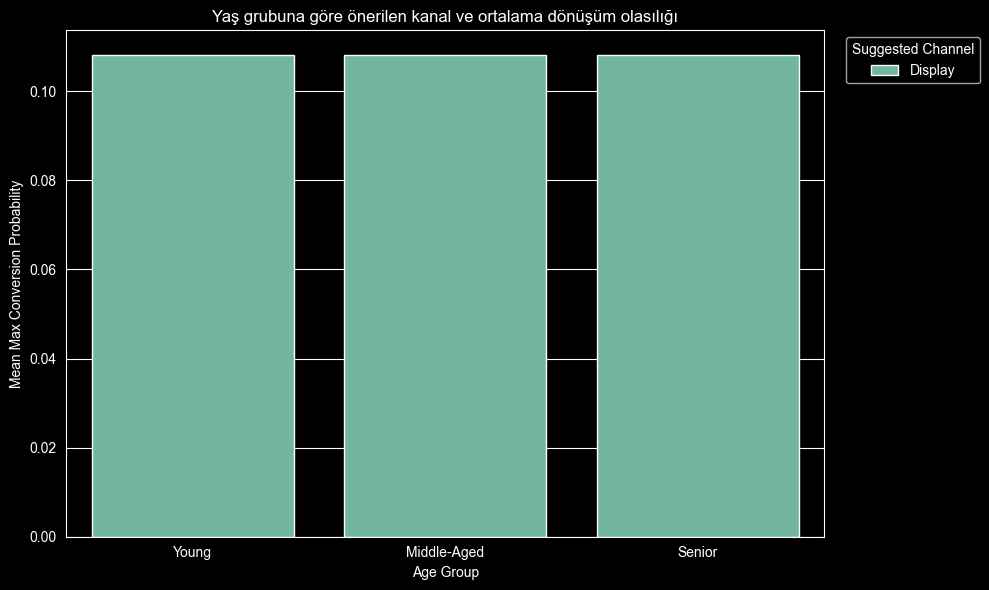

In [30]:
# Bar plot: X = Age Group, Y = Mean Max Conversion Prob, Hue = Suggested Channel
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=age_channel_prob,
    x="Age_Group_Phase3",
    y="Mean_Max_Prob",
    hue="Suggested_Channel",
    ax=ax,
    palette="Set2",
    order=["Young", "Middle-Aged", "Senior"],
)
ax.set_xlabel("Age Group")
ax.set_ylabel("Mean Max Conversion Probability")
ax.set_title("Yaş grubuna göre önerilen kanal ve ortalama dönüşüm olasılığı")
ax.legend(title="Suggested Channel", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
os.makedirs("../reports/05_recommender", exist_ok=True)
plt.savefig("../reports/05_recommender/age_group_channel_barplot.png", dpi=120, bbox_inches="tight")
plt.show()

## 3.3 The "Hidden Preference" Check

Eğer her segmente (Gelir × Yaş kırılımında) sadece o segmentin **en iyi kanalını** uygulasaydık, toplam beklenen conversion sayısında ne kadar artış (Expected Lift) olurdu? Her müşteriye kendi segmentinin en çok önerilen (kanal, platform) çiftini atayıp, modelden bu çift için tahmini olasılığı alıyoruz; toplam beklenen dönüşüm ile mevcut durumu karşılaştırıyoruz.

In [31]:
# Segment: Income (High/Low) x Age (Young, Middle-Aged, Senior)
df_test_seg = df_test.copy()
df_test_seg["Income_Segment"] = df_test_seg["Income"].apply(
    lambda x: "High-Income" if x >= df_test["Income"].median() else "Low-Income"
)

In [32]:
df_test_seg["Age_Group_Phase3"] = df_test_seg["Age"].apply(age_bin)
df_test_seg["Segment"] = df_test_seg["Income_Segment"] + " x " + df_test_seg["Age_Group_Phase3"]

In [33]:
# Her segment için en çok önerilen (kanal, platform) çifti
df_test_seg["recommended_channel"] = recommended_channel_list
df_test_seg["recommended_platform"] = recommended_platform_list
segment_best = (
    df_test_seg.groupby("Segment")
    .agg({"recommended_channel": lambda s: s.mode().iloc[0], "recommended_platform": lambda s: s.mode().iloc[0]})
    .reset_index()
    .rename(columns={"recommended_channel": "best_channel", "recommended_platform": "best_platform"})
)

In [34]:
# Her müşteriye kendi segmentinin "en iyi" (ch, pl) ile tahmin olasılığı
def get_prob_for_channel_platform(row, ch, pl):
    rec = recommend_action(row)
    pf = rec["prob_frame"]
    m = (pf["CampaignChannel"] == ch) & (pf["AdvertisingPlatform"] == pl)
    if m.any():
        return pf.loc[m, "Conversion_Probability"].iloc[0]
    return np.nan


In [35]:
prob_actual_total = lift_df["prob_actual"].sum()
prob_segment_best_list = []
for i in range(len(df_test_seg)):
    row = df_test_seg.iloc[i]
    seg = row["Segment"]
    best = segment_best[segment_best["Segment"] == seg].iloc[0]
    p = get_prob_for_channel_platform(row, best["best_channel"], best["best_platform"])
    prob_segment_best_list.append(p)

In [36]:
prob_segment_best_total = np.nansum(prob_segment_best_list)
expected_lift_segment = prob_segment_best_total - prob_actual_total
print("Mevcut (gerçek kanal) toplam beklenen dönüşüm (prob toplamı):", round(prob_actual_total, 4))
print("Segment-en iyi kanal uygulanırsa toplam beklenen dönüşüm:", round(prob_segment_best_total, 4))
print("Expected Lift (segment bazlı en iyi kanal - mevcut):", round(expected_lift_segment, 4))

Mevcut (gerçek kanal) toplam beklenen dönüşüm (prob toplamı): 821.0348
Segment-en iyi kanal uygulanırsa toplam beklenen dönüşüm: 1039.1904
Expected Lift (segment bazlı en iyi kanal - mevcut): 218.1555


 ## 3.4 Strategic Interpretation (Final Teşhis)

**1. Veri gerçekten homojen mi yoksa yaş/gelir kırılımında tercihler değişiyor mu?**

- Gelir medyanına göre **High-Income** ve **Low-Income** segmentlerinde en çok önerilen kanal/platform ikilisi yukarıda raporlandı. İki segmentte farklı kanallar öne çıkıyorsa veri homojen değildir; segment bazlı tercihler vardır.
- Yaş grupları (Young, Middle-Aged, Senior) bar plotunda, **Suggested Channel** (Hue) yaş grubuna göre değişiyorsa yine homojen olmayan, segment-spesifik bir yapı söz konusudur.
- Genel ortalamada tek bir "en iyi kanal" gibi görünmesi, bu kırılımlara bakılmadan yapılan değerlendirmenin gizli segment trendlerini maskelediği anlamına gelebilir.

**2. Pazarlama bütçesi genel bir havuzda mı toplanmalı yoksa spesifik segmentlere mi ayrılmalı?**

- **Segment bazlı Expected Lift** (3.3) pozitif ve anlamlıysa, her segment için "en iyi kanal"ı hedefleyen **segment-spesifik bütçe** (gelir/yaş kırılımına göre farklı kanal-platform mix’i) toplam beklenen dönüşümü artırıyor demektir; bu durumda bütçenin segmentlere göre ayrılması mantıklıdır.
- Lift düşük veya segmentler arası fark az ise, genel havuz + tek strateji daha sade ve yönetilebilir kalabilir; yine de test seti ve model sınırları (ör. ~0.15 F1) dikkate alınarak karar verilmelidir.
- Sonuç: Veri homojen değilse ve segment-spesifik öneri lift’i pozitifse **spesifik segmentlere bütçe ayrılması** önerilir; aksi durumda **genel havuz** tercih edilebilir.